# **Clustering the Data**

## Objectives

* We will investigate the data using clustering algoritthms to investigate our hypothesis # something

## Inputs

* The game data from before the train test split at the beginning of notebook 04. 

## Outputs

* A clustering model and some analysis of the underlying data set.

## Additional Comments
* This notebook follow the analysis done in notebook 07 of the Churnometer walkthrough project.

---

# Change working directory
We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os

home_dir = '/workspace/pp5-ml-dashboard'
os.chdir(home_dir)
current_dir = os.getcwd()
print(current_dir)

/workspace/pp5-ml-dashboard


We now load our prepared data.

In [2]:
import pandas as pd
from src.utils import get_df, save_df

game_data = get_df('game_pre_split', 'datasets/clean/csv')
game_data.set_index('game_id', inplace=True)

## Section 1: Set up problem
The game of basketball as evolved over the years. For example, we saw in our exploratory data analysis that there was a correlation between 3 pointers and year. We are going to test if clustering will detect the various eras of basketball, or perhaps it will define new ones.

We will then look at the profiles of each cluster to see how it groups games of basketball and try to determine if these clusters have any correlation with time.



In [3]:
game_data.drop(labels=['season'],inplace=True,axis=1)
game_data.head()

,fgm_home,fga_home,fg3m_home,fg3a_home,ftm_home,fta_home,oreb_home,dreb_home,reb_home,ast_home,...,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,home_wins,play_off
game_id,,,,,,,,,,,,,,,,,,,,,
28500005,41,92,0,3,9,18,16,28,44,25,...,29,40,21,11,7,17,19,100,0,0
28500006,39,88,0,2,26,41,20,28,48,17,...,31,42,19,7,7,18,32,108,0,0
28500010,39,88,0,1,40,49,17,40,57,23,...,28,41,27,10,7,20,32,116,1,0
28500011,42,82,0,2,24,38,10,24,34,30,...,30,47,23,10,7,19,28,112,0,0
28500008,36,91,0,4,33,52,18,29,47,17,...,31,44,26,11,3,22,40,119,0,0


Now we construct our pipeline for clustering. The format for the pipeline was inspired by the clustering pipeline in the Churnometer walkthrough project.

In [4]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from feature_engine import transformation as vt

TRANSFORM_ASSIGNMENT = {
    'yeo_johnson': ['dreb_away', 'blk_home', 'oreb_away', 'fta_away',
                    'dreb_home', 'ast_home', 'stl_away', 'pts_away',
                    'stl_home', 'reb_away', 'pts_home', 'fgm_away',
                    'oreb_home', 'pf_away', 'pf_home'],
    'box_cox': ['ast_away', 'fta_home']
    }
TRANSFORMS = {'box_cox':(vt.BoxCoxTransformer,False),
              'yeo_johnson':(vt.YeoJohnsonTransformer,False)}

def pipe_v1(thresh=0.7,p_components=50,clusters=50):
    pipe = Pipeline([
        ("corr_selector", SmartCorrelatedSelection(method="pearson",
                                                   threshold=thresh, 
                                                   selection_method="variance"))])
    pipe.fit(game_data)
    dropping = pipe['corr_selector'].features_to_drop_
    new_assignments = { key: [val for val in value if val not in dropping] 
                       for key,value in TRANSFORM_ASSIGNMENT.items()}
    for transform, targets in new_assignments.items():
        if not targets:
            continue
        pipe.steps.append(
            (transform, TRANSFORMS[transform][0](variables=targets))
            )
    pipe.steps.append(('scaler', StandardScaler()))
    pipe.steps.append(("PCA", PCA(n_components=p_components, random_state=42)))
    pipe.steps.append(("model", KMeans(n_clusters=clusters, random_state=42)))
    return pipe



We will end up tuning the number of clusters and components as hyperparameters. It will be interesting to luck at how the analysis changes as we move between the number of clusters. At each stage, we will see how the function that assigns each game to its season behaves on clusters.

## Section 2: PCA
We start by doing some Principal component analysis.

In [5]:
# to suppress warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logging.captureWarnings(True)
os.environ['PYTHONWARNINGS']='ignore'

pipe = pipe_v1()
pca_pipe = Pipeline(pipe.steps[:-2])
game_data_pca = pca_pipe.fit_transform(game_data)


We are now going to analyze the principal components. Feel free to adjust the number of components.

* The 15 components explain 97.89% of the data 



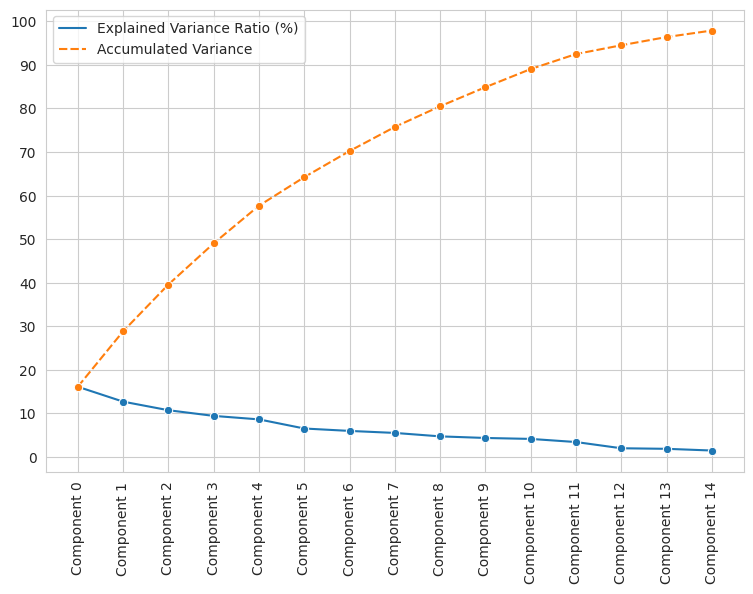

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


# This function is from the notebook 07 of the 
# churnometer walkthrough project.
def pca_component_analysis(df_pca, n_components):
    pca = PCA(n_components=n_components).fit(df_pca)

    ComponentsList = [f"Component {number}"
                      for number in range(n_components)]
    dfExplVarRatio = pd.DataFrame(
        data=np.round(100 * pca.explained_variance_ratio_, 3),
        index=ComponentsList,
        columns=['Explained Variance Ratio (%)'])

    dfExplVarRatio['Accumulated Variance'] = dfExplVarRatio['Explained Variance Ratio (%)'].cumsum(
    )
    PercentageOfDataExplained = dfExplVarRatio['Explained Variance Ratio (%)'].sum(
    )
    print(
        f"* The {n_components} components explain {round(PercentageOfDataExplained,2)}% of the data \n")
    plt.figure(figsize=(9, 6))
    sns.lineplot(data=dfExplVarRatio,  marker="o")
    plt.xticks(rotation=90)
    plt.yticks(np.arange(0, 110, 10))
    plt.show()


pca_component_analysis(game_data_pca, 15)


As we are hoping the data will be grouped into eras, each of which is multiple years long. We expect there to be a fair number of clusters, so we don't mind having many components.

* The 9 components explain 80.51% of the data 



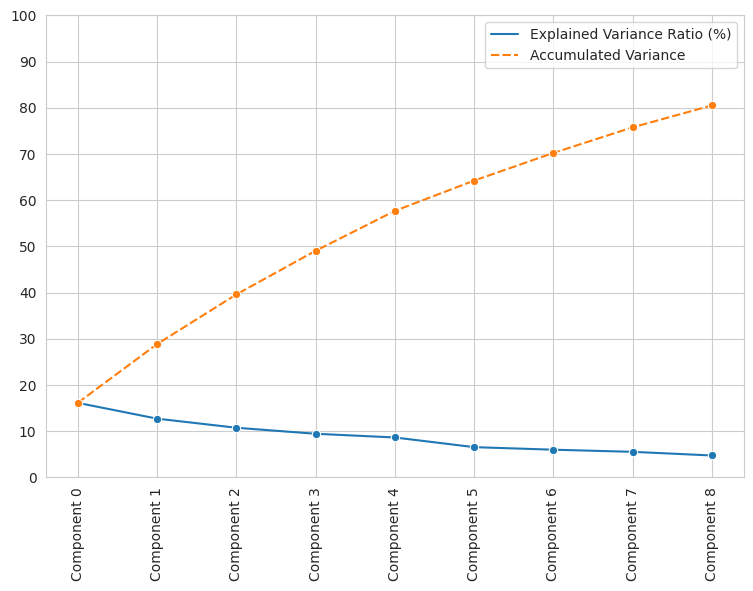

In [7]:
pca_component_analysis(game_data_pca,9)


So we redefine our pipeline creation function to have 9 as the number of components.

In [8]:
def pipe_v2(thresh=0.7,clusters=50):
    pipe = pipe_v1(thresh=thresh,p_components=9,clusters=clusters)
    return pipe

Now we need to use the elbow method and look at silhouette scores.

## Section 3: Elbow Method and Silhouette scores
These will help us determine the appropriate number of clusters to use for our algorithm. We are also taking into account some domain knowledge, which is that eras in basketball range from 6 to 10 years. It is not a well defined concept so we don't have a hard number. Our data set ranges from 1985 until 2022. So we (conservatively) expect there to be between 4 and 7 eras.

In [9]:
new_pipe = pipe_v2()
pca_part_of_pipe = Pipeline(new_pipe.steps[:-1])
game_data_pca = pca_part_of_pipe.fit_transform(game_data)

In [10]:
from yellowbrick.cluster import KElbowVisualizer

# This is from the notebook 07 of the 
# Churnometer walkthrough project.
visualizer = KElbowVisualizer(KMeans(random_state=42), k=(1,11))
visualizer.fit(game_data_pca) 
visualizer.show() 
plt.show()


KeyboardInterrupt: 

They are suggesting 4 clusters, but 6 also looks promising. Let's see how the Silhouette scores behave with respect to these different numbers of clusters.

=== Average Silhouette Score for different number of clusters ===


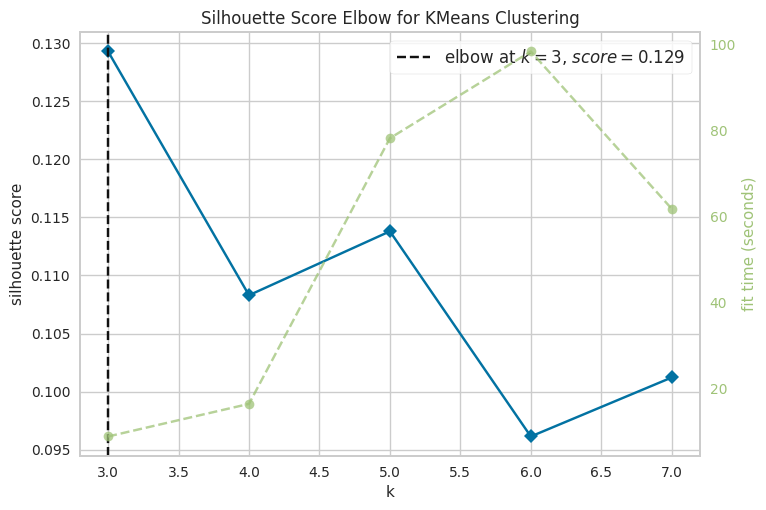



=== Silhouette plot for 3 Clusters ===


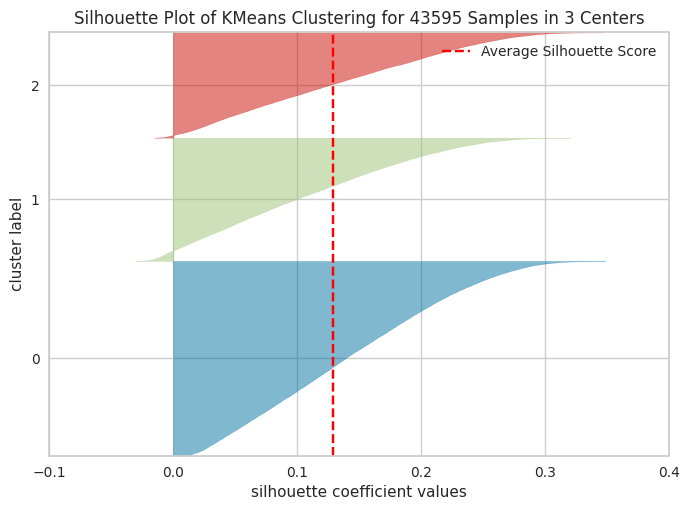



=== Silhouette plot for 4 Clusters ===


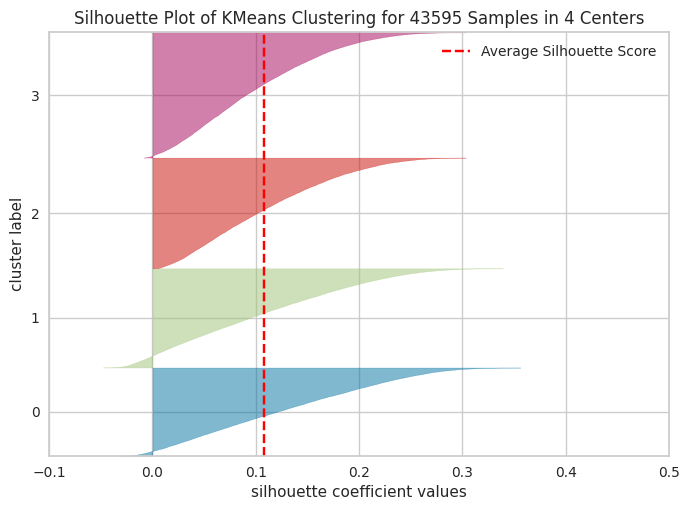



=== Silhouette plot for 5 Clusters ===


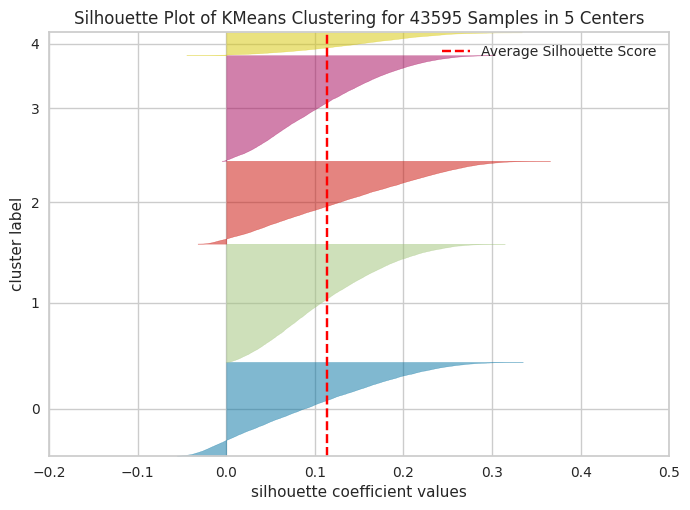



=== Silhouette plot for 6 Clusters ===


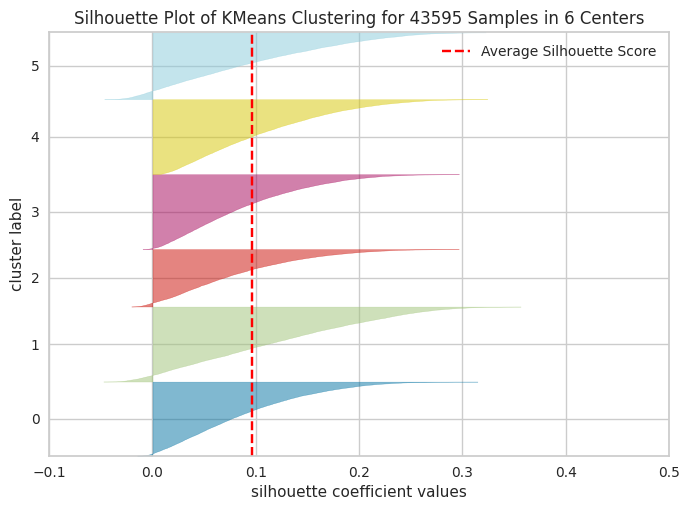



=== Silhouette plot for 7 Clusters ===


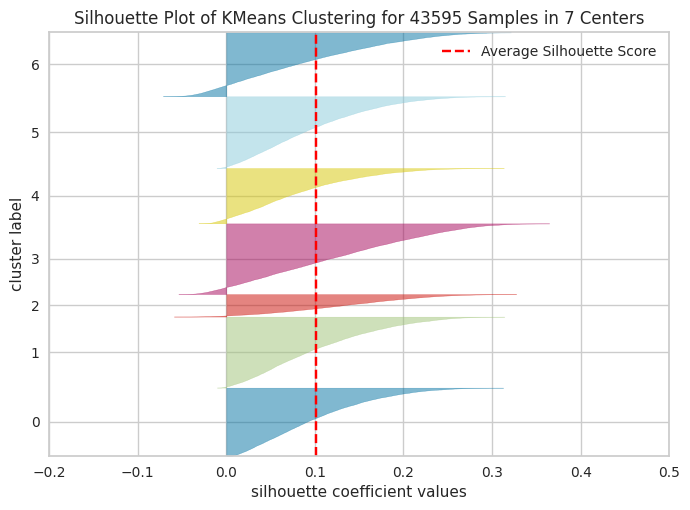

In [ ]:
from yellowbrick.cluster import SilhouetteVisualizer

n_cluster_start = 3
n_cluster_stop = 8

# This is from the notebook 07 of the 
# churnometer walkthrough project.
print("=== Average Silhouette Score for different number of clusters ===")
visualizer = KElbowVisualizer(KMeans(random_state=42), k=(
    n_cluster_start, n_cluster_stop), metric='silhouette')
visualizer.fit(game_data_pca)
visualizer.show()
plt.show()
print("\n")


for n_clusters in np.arange(start=n_cluster_start, stop=n_cluster_stop):

    print(f"=== Silhouette plot for {n_clusters} Clusters ===")
    visualizer = SilhouetteVisualizer(estimator=KMeans(n_clusters=n_clusters,
                                                       random_state=42),
                                      colors='yellowbrick')
    visualizer.fit(game_data_pca)
    visualizer.show()
    plt.show()
    print("\n")



The analysis suggest using 3 clusters. After adding the clustering data to the data frame we will see if the clustering correlates with the `season` feature.

In [10]:
pipe_w_clusters = pipe_v2(clusters=3)
game_w_clusters = game_data.copy()
game_w_clusters.head()

,fgm_home,fga_home,fg3m_home,fg3a_home,ftm_home,fta_home,oreb_home,dreb_home,reb_home,ast_home,...,dreb_away,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,home_wins,play_off
game_id,,,,,,,,,,,,,,,,,,,,,
28500005,41,92,0,3,9,18,16,28,44,25,...,29,40,21,11,7,17,19,100,0,0
28500006,39,88,0,2,26,41,20,28,48,17,...,31,42,19,7,7,18,32,108,0,0
28500010,39,88,0,1,40,49,17,40,57,23,...,28,41,27,10,7,20,32,116,1,0
28500011,42,82,0,2,24,38,10,24,34,30,...,30,47,23,10,7,19,28,112,0,0
28500008,36,91,0,4,33,52,18,29,47,17,...,31,44,26,11,3,22,40,119,0,0


Now we will fit both of these pipelines and see what they tell us.

In [11]:
pipe_w_clusters.fit(game_w_clusters)

Pipeline(steps=[('corr_selector',
                 SmartCorrelatedSelection(selection_method='variance',
                                          threshold=0.7,
                                          variables=['fgm_home', 'fga_home',
                                                     'fg3m_home', 'fg3a_home',
                                                     'ftm_home', 'fta_home',
                                                     'oreb_home', 'dreb_home',
                                                     'reb_home', 'ast_home',
                                                     'stl_home', 'blk_home',
                                                     'tov_home', 'pf_home',
                                                     'pts_home',
                                                     'plus_minus_home',
                                                     'fgm_away', 'fga_away',
                                                     'fg3m_away', 'fg3a_away',
   

In [12]:
#game_data_w_seasons = get_df('game_pre_split', 'datasets/clean/csv')
#game_id_season = game_data_w_seasons.filter(['game_id','season'])
def get_season(game_id):
    return game_id_season.query(f"game_id == {game_id}")['season']
    #game_data_w_seasons.loc[game_id, 'season']
    # ai suggested the above but I think it should be this one
    #return game_data_w_seasons.loc[game_id]['season']
#game_test = game_w_clusters.copy()
#game_test['season'] = game_test.apply(lambda x: get_season(x.name), axis=1)
#print(game_test.head())
'''
for i in range(5):
    for _, row in game_test.iterrows():
        game_w_clusters.iloc[_, 'season'] = get_season(row.name)
'''

"\nfor i in range(5):\n    for _, row in game_test.iterrows():\n        game_w_clusters.iloc[_, 'season'] = get_season(row.name)\n"

In [13]:
game_w_clusters['Clusters'] = pipe_w_clusters.predict(game_data)

game_w_clusters.head()

,fgm_home,fga_home,fg3m_home,fg3a_home,ftm_home,fta_home,oreb_home,dreb_home,reb_home,ast_home,...,reb_away,ast_away,stl_away,blk_away,tov_away,pf_away,pts_away,home_wins,play_off,Clusters
game_id,,,,,,,,,,,,,,,,,,,,,
28500005,41,92,0,3,9,18,16,28,44,25,...,40,21,11,7,17,19,100,0,0,1
28500006,39,88,0,2,26,41,20,28,48,17,...,42,19,7,7,18,32,108,0,0,1
28500010,39,88,0,1,40,49,17,40,57,23,...,41,27,10,7,20,32,116,1,0,1
28500011,42,82,0,2,24,38,10,24,34,30,...,47,23,10,7,19,28,112,0,0,1
28500008,36,91,0,4,33,52,18,29,47,17,...,44,26,11,3,22,40,119,0,0,1


* Cluster frequencies 
   Clusters
0      0.46
1      0.29
2      0.25 




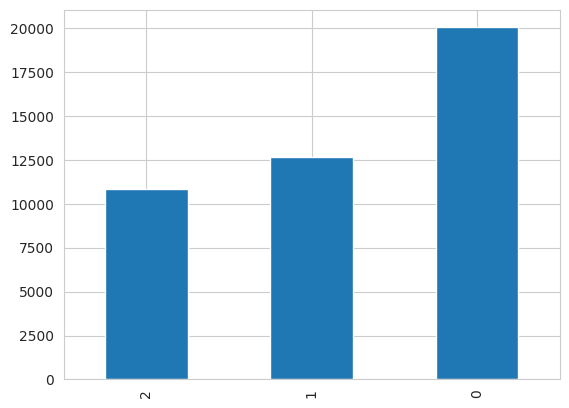

In [14]:
print(f"* Cluster frequencies \n{game_w_clusters['Clusters'].value_counts(normalize=True).to_frame().round(2)} \n\n")
game_w_clusters['Clusters'].value_counts().sort_values().plot(kind='bar')
plt.show()

Let's investigate how the clusters and the components from the PCA relate to one another.

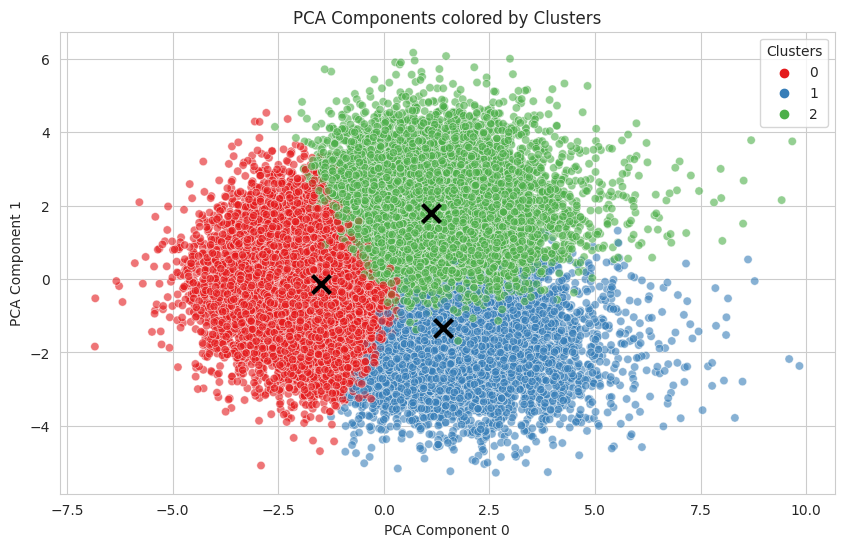

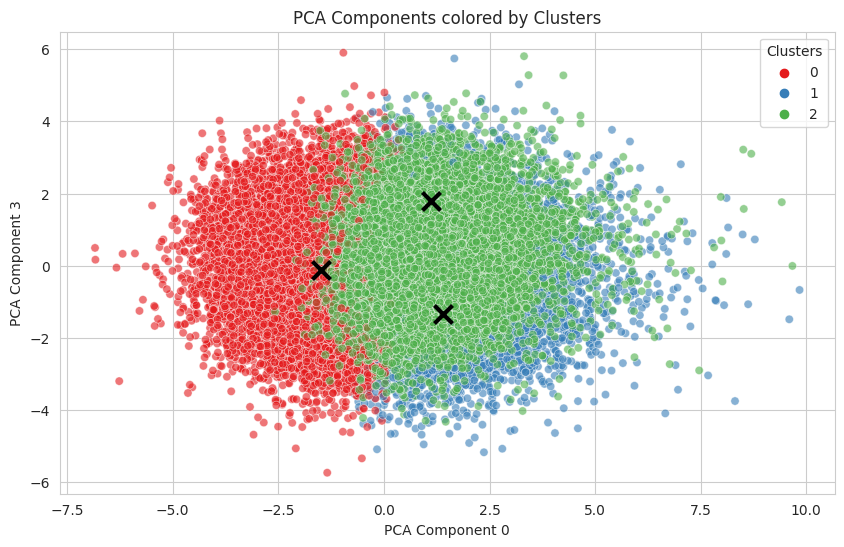

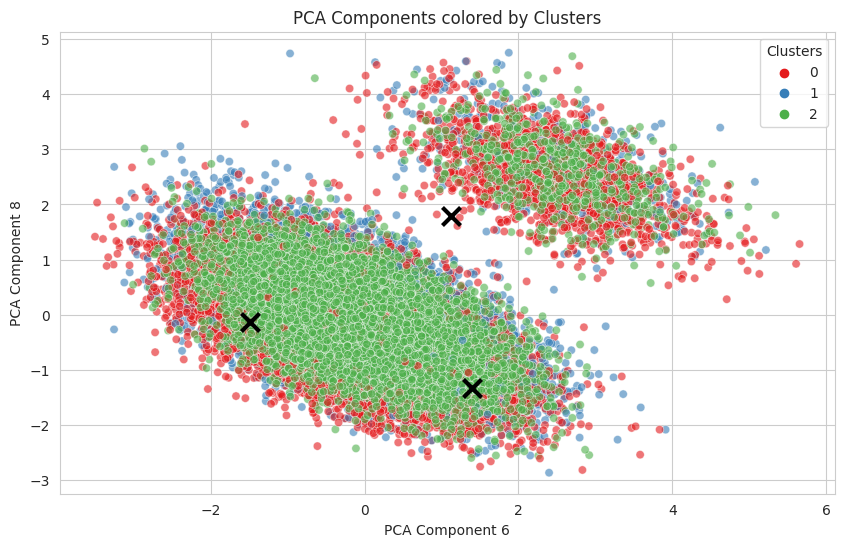

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.set_style("whitegrid")


def compare_components_w_clusters(a:int,b:int,pca_step,cluster_step,pipe):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=pca_step[:, a], y=pca_step[:, b],
                hue=cluster_step['Clusters'], palette='Set1', alpha=0.6)
    plt.scatter(x=pipe['model'].cluster_centers_[:, 0],
            y=pipe['model'].cluster_centers_[:, 1],
            marker="x", s=169, linewidths=3, color="black")
    plt.xlabel(f"PCA Component {a}")
    plt.ylabel(f"PCA Component {b}")
    plt.title("PCA Components colored by Clusters")
    plt.show()

interesting_pairs = [(0,1), (0,3), (6,8)]
for a,b in interesting_pairs:
    compare_components_w_clusters(a, b, game_data_pca, game_w_clusters,
                                  pipe_w_clusters)


Feel free to look at how other components compare with respect to the clusters. We felt these three were the most interesting.

## Cluster Profile
We next wish to determine the profile of these clusters. We do this by training a classification model on the data with the clusters as the target. The important features of the models will help us to determine the profiles of the individual clusters.

In our model selection notebook, we found that AdaBoost and Logistic Regression were good models for working with this data. We will use AdaBoost as it works one multi-class classification problems without any need for adjustment.

In [16]:
# This will be our target variable.
cluster_predictions = game_w_clusters['Clusters']

# This will be our data.
df = game_w_clusters.copy()

In [17]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
                    df.drop(['Clusters'], axis=1),
                    df['Clusters'], test_size=0.2,
                    random_state=42)

print(X_train.shape)
print(X_test.shape)

(34876, 33)
(8719, 33)


Now we create our classifier pipeline. We will try it with the default parameters as well as the parameters we found in the last notebook.

In [18]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel


def clf_pipe(thresh=0.7, params={}):
    pipe = Pipeline([
        ('corr_selector',
         SmartCorrelatedSelection(method="pearson",
                                  threshold=thresh,
                                  selection_method="variance"))
                        ])
    pipe.fit(X_train)
    dropping = pipe['corr_selector'].features_to_drop_
    new_assignments = { key: [val for val in value if val not in dropping] 
                       for key,value in TRANSFORM_ASSIGNMENT.items()}
    for transform, targets in new_assignments.items():
        if not targets:
            continue
        pipe.steps.append(
            (transform, TRANSFORMS[transform][0](variables=targets))
            )
    pipe.steps.append(('scaler', StandardScaler()))
    model = AdaBoostClassifier(random_state=42,**params)
    pipe.steps.append(("feat_selection", SelectFromModel(model)))
    pipe.steps.append(('model',model))
    return pipe

ada_thresh = 0.8
ada_params = {'n_estimators': 110, 'learning_rate': 1.133,
              'algorithm': 'SAMME.R'}

In [19]:
default_ada_pipe = clf_pipe()
default_ada_pipe.fit(X_train, y_train)
tuned_ada_pipe = clf_pipe(thresh=ada_thresh, params=ada_params)
tuned_ada_pipe.fit(X_train, y_train)


Pipeline(steps=[('corr_selector',
                 SmartCorrelatedSelection(selection_method='variance',
                                          variables=['fgm_home', 'fga_home',
                                                     'fg3m_home', 'fg3a_home',
                                                     'ftm_home', 'fta_home',
                                                     'oreb_home', 'dreb_home',
                                                     'reb_home', 'ast_home',
                                                     'stl_home', 'blk_home',
                                                     'tov_home', 'pf_home',
                                                     'pts_home',
                                                     'plus_minus_home',
                                                     'fgm_away', 'fga_away',
                                                     'fg3m_away', 'fg3a_away',
                                                     'ftm_aw

In [20]:
from sklearn.metrics import classification_report

print("Default AdaBoost:")
default_predicted = default_ada_pipe.predict(X_train)
print(classification_report(y_train,default_predicted))
print("="*15)
print("="*15)
print("Tuned AdaBoost:")
tuned_predicted = tuned_ada_pipe.predict(X_train)
print(classification_report(y_train,tuned_predicted))


Default AdaBoost:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93     16090
           1       0.91      0.86      0.88     10137
           2       0.91      0.92      0.92      8649

    accuracy                           0.91     34876
   macro avg       0.91      0.91      0.91     34876
weighted avg       0.91      0.91      0.91     34876

Tuned AdaBoost:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95     16090
           1       0.93      0.88      0.91     10137
           2       0.94      0.95      0.94      8649

    accuracy                           0.93     34876
   macro avg       0.93      0.93      0.93     34876
weighted avg       0.93      0.93      0.93     34876



Both classifiers are good, but the one with the hyperparameters from the last notebook performs slightly better. Let's look at what the important features are.

In [34]:
from src.notebook_functions import feature_importance_tree_based_models

type(tuned_ada_pipe['model'])

sklearn.ensemble._weight_boosting.AdaBoostClassifier